Load the image

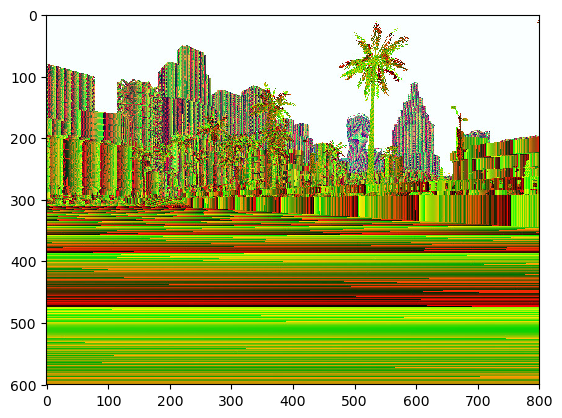

In [5]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D

 
# Read Images
img = mpimg.imread('Rubens test files/Pictures/Depth_image.jpg') #to check the picture
img2 = mpimg.imread('Rubens test files/Pictures/instance_camera_Fri_Apr_12_11_27_18_2024.png')
depth_data=plt.imread('Rubens test files/Pictures/Depth_image.jpg') #to get the data as an array
segment_data=plt.imread('Rubens test files/Pictures/instance_camera_Fri_Apr_12_11_27_18_2024.png') #to get the data as an array
# Output Images
plt.imshow(img)
#plt.imshow(img2)



Initiate variables

In [6]:
depth_Width=round(depth_data[1,:].size/3)
depth_Height=round(depth_data[:,1].size/3)

segment_Width=round(segment_data[:,1].size/3)
segment_Height=round(segment_data[1,:].size/3)


converted_depth_data=np.zeros([depth_Width,depth_Height])
segment_data=np.round(segment_data*255)

max_sensor_range= 0.4 #in kilometers
#w2c=camera.get_transform

Calculate costmap


In [7]:
#convert depth units
R=depth_data[:,:,0]
G=depth_data[:,:,1]
B=depth_data[:,:,2]

normalized = ((R + G * 256 + B * 256 * 256) / (256 * 256 * 256 - 1))*1000

#calculate projection matrix
fov = 90
im_size_x = 800
im_size_y = 600

f  = im_size_x /(2.0 * math.tan(fov * math.pi / 360))
Cx = im_size_x / 2.0
Cy = im_size_y / 2.0

K = np.array([[f, 0, Cx], [0, f, Cy], [0, 0, 1]], dtype=np.float64)
K_inv=np.linalg.inv(K)

#convert the image data to points

rel_coords=get_point_image(normalized,K_inv,depth_Width,depth_Height)

print(normalized)

[[3.9058926  3.9058926  3.9058926  ... 3.9058926  3.9058926  3.9058926 ]
 [3.9058926  3.9058926  3.9058926  ... 3.9058926  3.9058926  3.9058926 ]
 [3.9058926  3.9058926  3.9058926  ... 3.9058926  3.9058926  3.9058926 ]
 ...
 [2.25573792 2.25573792 2.25573792 ... 2.25454582 2.25454582 2.25454582]
 [2.29370608 2.29370608 2.29370608 ... 2.29251398 2.29251398 2.29251398]
 [2.28601708 2.28601708 2.28601708 ... 2.28482498 2.28482498 2.28482498]]


In [17]:
#we use np.division to quickly do elementwise matrix division where dividing by 0 equals 1

focal_mat=np.ones_like(rel_coords[:,:,0])


c_squared=np.square(focal_mat)+np.square(rel_coords[:,:,1])
d=np.power(np.square(rel_coords[:,:,0])+c_squared, 0.5*np.ones_like(rel_coords[:,:,0]))

#Create a condition to bypass the division incase of zeros
condition= (np.square(rel_coords[:,:,0]) + np.square(rel_coords[:,:,1]))!=0

#cant put a scalar in np.divide so we use ones
placeholder=np.ones_like(rel_coords[:,:,0])

a  = np.divide(placeholder, d, out=np.zeros_like(placeholder), where= condition)
x= a*normalized*rel_coords[:,:,1]
y= a*normalized
np.size(y)

480000

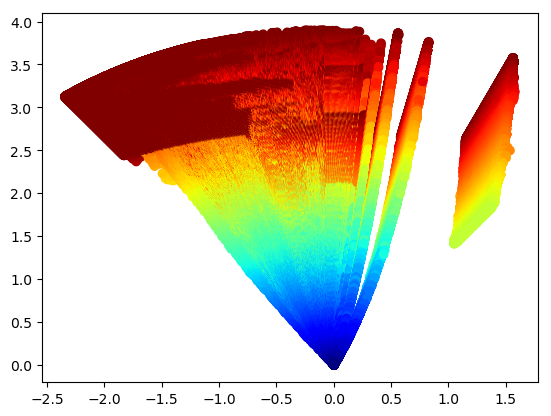

In [15]:
plt.scatter(x,y,c=normalized,cmap='jet')


TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

In [ ]:
# def get_image_point(loc, K,w2c):
#         # Calculate 2D projection of 3D coordinate

#         # Format the input coordinate (loc is a carla.Position object)
#         point = np.array([loc.x, loc.y, loc.z, 1])
#         # transform to camera coordinates
#         point_camera = np.dot(w2c, point)

#         # New we must change from UE4's coordinate system to an "standard"
#         # (x, y ,z) -> (y, -z, x)
#         # and we remove the fourth componebonent also
#         point_camera = [point_camera[1], -point_camera[2], point_camera[0]]

#         # now project 3D->2D using the camera matrix
#         point_img = np.dot(K, point_camera)
#         # normalize
#         point_img[0] /= point_img[2]
#         point_img[1] /= point_img[2]

#         return point_img[0:2]

def get_point_image(point_img,K_inv,Width,Height):
        loc_mat=np.zeros([Height,Width,3])
        static_projection_matrix=np.zeros([Height,Width,3])
        for i in range(Height):
                for j in range(Width):
                        loc_mat[i,j] = [j,i,1]
                        static_projection_matrix[i,j]=np.dot(K_inv,loc_mat[i,j])
        return static_projection_matrix
        
        
def get_point_world_coordinates(point_img, K_inv, R, t, Height, Width):
    loc_mat = np.zeros([Height, Width, 3])  # Corrected dimensions
    camera_coordinates = np.zeros([Height, Width, 3])  # Corrected dimensions
    world_coordinates = np.zeros([Height, Width, 3])  # Corrected dimensions
    for i in range(Height):
        for j in range(Width):  # Corrected order of Height and Width
            loc_mat[i, j] = [j, i, 1]  # Corrected order of j and i
            camera_coordinates[i, j] = np.dot(K_inv, loc_mat[i, j]) * point_img[i, j]  
            world_coordinates[i, j] = np.dot(R, camera_coordinates[i, j]) + t.reshape(3,)
    return world_coordinates

In [ ]:
loc_mat=np.zeros([4,3,3])
mat2=np.zeros([4,3])
np.dot(mat2,loc_mat[1,1])

array([0., 0., 0., 0.])